#1. Introduction


## 1-1. object detection 에 사용된 다양한 방법

이미지 내 존재하는 다양한 크기의 객체를 인식하는 것은 Object detection task의 핵심적인 문제다. <br> 모델이 크기에 상관없이 객체를 detect할 수 있도록 다양한 방법을 사용해왔다. 아래는 object detection에 사용된 방법들이다.

### 1) Featurized image pyramid 

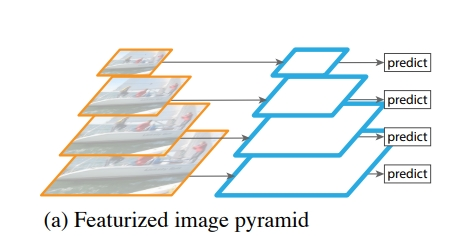

#### ex) MTCNN

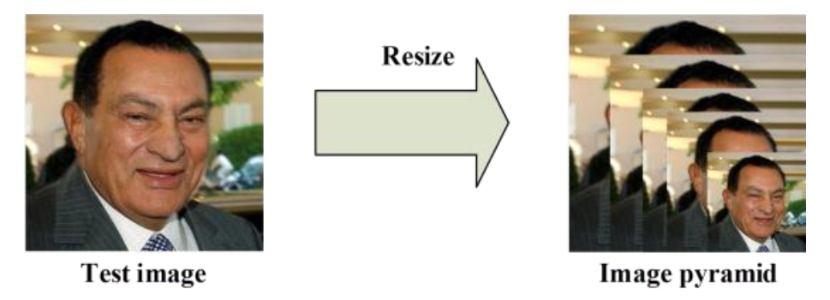

 1. input되는 이미지를 각기 다른 scale로 resize하여 image pyramid를 만든다. 

 2. 
  단점> 각각 이미지 스케일에 따라 독립적으로 compute되어야하기 때문에 매우 느리다. 또한 메모리를 지나치게 많이 사용한다.


- - -

### 2) Single feature map

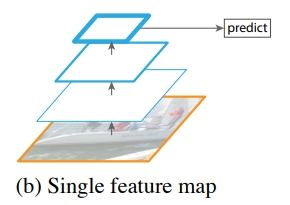

#### ex) yolo version 1

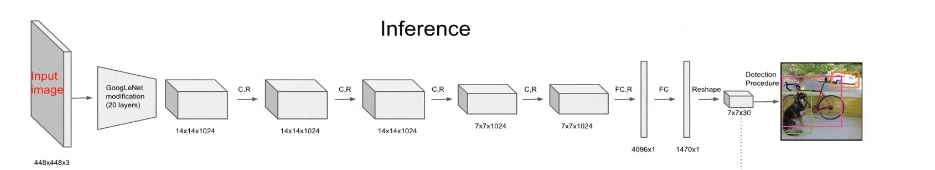

1. 단일 scale의 입력 이미지를 네트워크에 입력하여 단일 scale의 feature map을 통해 object detection을 수행하는 방법이다.

2. 장점> 학습 및 추론 속도가 매우 빠르다.

   단점> 성능이 떨어진다

- - -

### 3) Pyramidal feature hierarchy

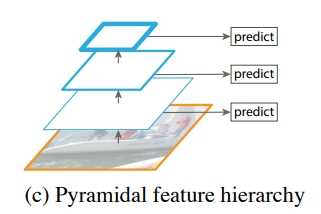

#### ex) SSD

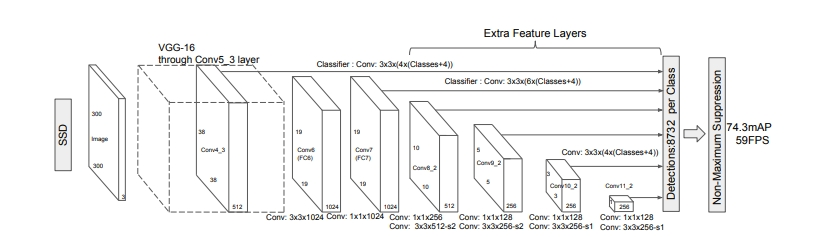


1. 네트워크에서 미리 지정한 conv layer마다 feature map을 추출하여 detect하는 방법이다.  

2. 장점> 
중간계층의 다양한 피쳐맵(Feature Map)들을 활용할 뿐만아니라 FC Layer계층을 컨볼루션 연산으로 대체함으로써, 성능과 속도를 향상시켰다. 

 단점>
 >feature map 간 해상도 차이로 인해 학습하는 representation에서 차이인 semantic gap이 발생한다는 문제가 있다. 

 > 얕은 layer에서 추출한 feature map에서 저수준 특징(low-level feature)까지 객체 인식률이 낮아진다. 

 


- - -

## 1-2. 기존의 방식의 문제점

1) 모델의 추론 속도가 너무 느리다.

2) 메모리를 지나치게 많이 사용한다는 문제가 있다. 
> 본 논문에서는 FPN(Feature Pyramid Network)을 통해 컴퓨팅 자원을 적게 차지하면서 다양한 크기의 객체를 인식하는 방법을 제시한다.

- - -

## 1-3. Feature Pyramid Network

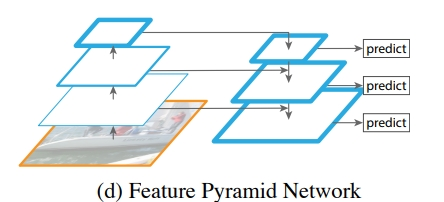

### 장점
> 상위 레벨의 이미 계산 된 특징을 재사용 하므로 멀티 스케일 특징들을 효율적으로 사용 할 수 있다. 

 >CNN 자체가 레이어를 거치면서 피라미드 구조를 만들고 forward 를 거치면서 더 많은 의미(Semantic)를 가지게 된다. 

 >각 레이어마다 예측 과정을 넣어서 Scale 변화에 더 강한 모델이 되는 것이다. 

 > forward 에서 추출된 의미 정보들을 top-down 과정에서 업샘플링하여 해상도를 올리고 forward에서 손실된 지역적인 정보들을 skip connection 으로 보충해서 스케일 변화에 강인하게 되는 것이다.

- - -

## 1-4. SSD에서 나타난 semantic gap와, resolution 문제 해결방법

- Semantic이 강한 low resolution(top layer를 의미)과 semantic이 약한 high-resolution을 연결하여 사용한다.
 
- top-down pathway에서 coarse feature map을 2배 up sampling하여 higher resolution을 갖는다.

- lateral connection으로 부터 소실된 high-resolution 정보를 추가한다. 

### 참조그림

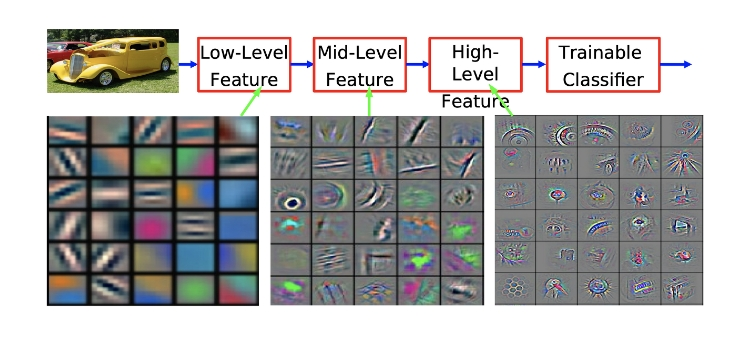

convolutional network에서 더 얕은, 즉 입력층에 보다 가까울수록 feature map은 높은 해상도(high resolution)을 가지지며, 가장자리, 곡선 등과 같은 저수준 특징(low-level feature)을 보유하고 있다. 반대로 더 깊은 layer에서 얻을 수 있는 feature map은 낮은 해상도(low resolution)을 가지며, 질감과 물체의 일부분 등 class를 추론할 수 있는 고수준 특징(high-level feature)을 가지고 있다.

\

- - -

# 2. FPN : Feature Pyramid Networks

<img src='https://drive.google.com/uc?export=download&id=1dlqb_zXzCODFI4-ExNt5biDD6-zE644P' height="400" width="600"><br>
- ResNet architecture
- **ResNet**을 BackBone으로 사용한다.
> ResNet의 skip connection으로 기존의 VGG 네트워크보다 더 깊지만 <br>
기존 layer를 보존하면서 residual block 더해주기 때문에 error를 낮춰주고 <br> 깊이가 깊어질수록 높은 정확도 향상을 보이는 장점을 가져온다.

## 2-1. Feature Pyramid Networks
- 목표 : low-level부터 high-level까지 ConvNet의 피라미드 계층을 활용하고, high-level에서 feature 피라미드를 만드는 것

### **Process**

<img src='https://drive.google.com/uc?export=download&id=1NMngyrkkKHvz2O7JVzSXcRI_L8mYkOJE' height="700" width="1100">

### 1) Input이미지를 Conv 연산한다. (Bottom-up pathway)
- Bottom-up pathway
> 정의 : ConvNet BackBone의 feedforward 계산 <br>
> stage별로 **scaling step=2**로 두고 conv 계산한다.

- 동일한 크기의 feature map을 출력하는 layers들을 동일한 stage로 묶는다.<br>
> ResNet에서 padding이 적용된 conv layer를 거치면 <br>
input값과 동일한 크기의 feature map이 생성되는데 <br>
하나의 stage로 보는것이다.
- input image를 기준으로 conv2, conv3, conv4, conv5의 stride를 $\{4, 8, 16, 32\}$로 설정된다.<br>
>  ResNet에서 Residual block으로 conv2, conv3, conv4, conv5의 output인 $\{C_2, C_3, C_4, C_5\}$를 정의한다.
- *Conv1는 메모리가 크기때문에 피라미드에 포함하지않는다.*

### 2) $C_5$를 1x1 conv (ch:256) 연산해서 feature map M5을 생성한다.

### 3) Upsampling을 통해 하위 feature map($C_4$)과 사이즈를 맞춰준다. (Top-down pathway)
- Top-down pathway <br>
<img src='https://drive.google.com/uc?export=download&id=1DryQ8kcnyFsXMN3EXkl4uBkaFJs3foNe' height="250" width="450"> <br>
> - nearest Neighbor를 사용해서 상위 feature map을 **2배**로 키워서(upsampling)
 사이즈를 맞추고 해상도를 높인다.

### 4) $C_4$를 1x1 conv (ch:256) 연산한다.(lateral connections)
- lateral connections <br>
<img src='https://drive.google.com/uc?export=download&id=1VS9YeB0XqwCcFfbLJlD70wczM-14nyDX' height="350" width="350"> <br>
> - 하위 feature map에 feature map의 channel을 감소시키기위해 1x1 conv를 적용하고 <br>
(여기서 1x1 fiter channel은 모두 256으로 지정한다.)

### 5) upsampling한 3번 feature map과 element-wise 연산후 feature map M4를 생성한다.


### 6~11)까지 upsampling, top-down pathway, lateral connection을 반복해서 진행한다.

### 12~15) 연산한 feature map$\{M2, M3, M4, M5\}$에 3x3 conv연산을 한다.
> 3x3 conv연산하는 이유 : **upsampling을 하면서 원본 정보가 뒤틀리는 aliasing effect를 줄이기 위해서** <br>
>> 이 결과로 나온 feature map을 $\{P_2, P_3, P_4, P_5\}$라고 부르고 <br>
>>$\{C_2, C_3, C_4, C_5\}$와 동일한 사이즈를 가진다.

# 3. Feature Pyramid Networks for RPN

<img src='https://drive.google.com/uc?export=download&id=1-mivPUp0Qc5ptccYAqBOfNtixGINk8lU' height="500" width="450"> <br>

앞의 과정에서 얻은 __feature map p2, p3, p4, p5를 RPN(Region Proposal Network)의 head 부분에 입력한다.__ <br>
일반적으로 object detection에서 피쳐맵을 뽑는 부분을 backbone, detecting을 하는 부분을 head라고 한다. <br>
(RPN의 자세한 내용은 Faster R-CNN 논문 참조) <br>
각 feature map은 위의 그림과 같이 개별적으로 RPN head에 넣어주고 각각의 class score과 bounding box regressor를 출력한다. <br>
이후 NMS(Non maximum suppression)를 적용하여 class score가 높은 top N-rank(상위 1000개)의 RoI(Region of Interest)들을 출력하게 된다.

# 4. Featur Pyramid Networks for Fast R-CNN

FPN으로 뽑은 각 피쳐맵에 RPN head를 적용하여 얻게된 RoI(Region of Interest)들은 <br>
Fast R-CNN 에서 마지막 classification(어떤 클래스인지)과 box regression을 위해 RoI Pooling 후 <br>FCL(Fully Connected Layer)에 연결해주듯이 이 단계에서도 <br>
RoI Pooling을 통해  제각각의 RoI들을 같은 사이즈의 인풋으로 맞춰줄 수 있다. <br>

<img src='https://drive.google.com/uc?export=download&id=1UtZjz7EQVXPFkW_bFCmovT2bS81acePt' height="270" width="900"> <br>

위와같이 기존의 Fast R-CNN모델이나 Faster R-CNN 모델은 <br>
Region proposal method(각각 Selective Search, RPN)을 통해 RoI를 추출하고, <br>
이를 이전에 나온 하나의 피쳐맵에 투영해 RoI Pooling을 적용한다. <br>


<img src='https://drive.google.com/uc?export=download&id=1E8ezZvI7rpQNiACgify6uozf0wGJs_ET' height="300" width="900"> <br>


FPN을 적용한 이 모델에서는 P2, ... , P5에 이르는 다양한 크기의 피쳐맵을 생성했고 <br> 
각각의 피쳐맵에서 RoI가 생성되기때문에 RoI Pooling 시에도 각각의 피쳐맵에 투영시켜야 한다. <br>
이 문제를 해결하기 위해 논문에서는 다음의 수식을 설정했다. <br>

$k = [ k_0 + log_2(\sqrt{wh}/224) ]$

* $k$ = 피쳐맵의 번호
* 224 = pre-trained 된 ImageNet 사이즈
* $w,h$ = 해당 RoI 가로,세로 크기
* $k_0$ = 4

예를들면, 512x512 크기의 RoI가 입력으로 들어왔다면 4+log2(2.28) = 5.11로 P5에 투영된다. <br> 
공식을 보면 자연스럽게 더 작은 사이즈의 RoI일 수록 더 큰 해상도 <br>
(input 이미지와 가까운 곳에서 생성된 피쳐맵)에 투영되는걸 알수있다. <br>
이렇게 큰 물체부터 작은 물체까지 모두 유의미한(semantic value)정보를 가진 <br> 피쳐맵으로부터 다양한 크기의 물체를 감지할 수 있게 된다. <br>

<img src='https://drive.google.com/uc?export=download&id=1A_An-rmc31VdueIV47zwIII17_wrXKr-' height="250" width="500">

기존의 ResNet의 conv5 layer대신, 생성된 RoI를 7x7로 RoI Pooling한 뒤 <br> 이것을 2개의 fully-connected layers에 붙이게 된다. <br>
그리고 기존 Fast R-CNN방식대로 최종적인 Classification과 bounding box regression을 하게 된다. <br>
원래 ResNet에는 pre-trained된 fully-connected layers가 없었으니 가중치들을 랜덤하게 초기화해준다. <br>
이는 기존의 conv5 layer를 사용하는것보다 가볍고 빠르다고 한다. <br>

<img src='https://drive.google.com/uc?export=download&id=1JmU9A412_buk4B5uPZLaiRU12i6cRvo6' height="450" width="900">

전체 과정을 도식화해보면 위와 같다. <br>
실제 inference 시에는 마지막 예측에 Non-Max Suppression을 적용하여 최적의 예측 결과만을 출력한다. <br>

# 5. Conclusion

<img src='https://drive.google.com/uc?export=download&id=1Tk5ylb_clgtH32AOk82cDoMRY-prcuKf' height="200" width="900">

backbone network로 ResNet을 사용한 Faster R-CNN에 FPN을 결합시켰을 때, <br>
테스트 결과는 FPN을 사용하지 않았을 때보다 AP값이 8% 이상 향상되었다. <br>
또한 FPN을 포함해 end-to-end로 학습이 가능하며, 학습 및 테스트 시간이 일정하여 메모리 사용량이 적다는 장점들이 있다. <br>
 

SSD에서 이미 각각의 피쳐맵을 detecting에 활용하는 아이디어를 얻었지만 <br>
네트워크층이 얕은(input 이미지와 가까운 위치에서 얻은 피쳐맵) 위치에서는 <br>
의미있는 정보를 뽑아내지 못했고 이는 작은 물체를 감지하는데 어려움이 있었다. <br>

FPN 논문에서는 semantic value가 높은 피쳐맵과 localization에 유리한 피쳐맵 모두를 활용할 수 있는 좋은 아이디어를 얻을 수 있었다. <br>

---

Image & Reference

[paper](https://arxiv.org/pdf/1612.03144.pdf)
[1](https://herbwood.tistory.com/18) [2](https://junha1125.github.io/blog/artificial-intelligence/2020-08-18-YOLO/) [3](https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf) [4](https://arxiv.org/pdf/1512.02325.pdf) [5](https://wikidocs.net/162976) [6](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)
[7]()